In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from yaml import dump
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

# import gpumap
from c3linearize import linearize, class_graph

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets


from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

fig.initialize('sae')
from omnifig.projects import sae
import networkx as nx

# from src import sample_full_interventions, response_mat, factor_reponses
dataset = None
src = None
def viz(config): # Utility function to print out config objects nicely
    print(dump(config.pythonize()), end='')

In [2]:
device = 'cuda'
figure_dir = Path('../learn_rep/figures/extrapolation')
# figure_dir = None
# figure_root = None
seed = 10
torch.manual_seed(seed)

src = None

num_nodes = 5

B = 48
N = num_nodes + 3
G = 32
C = 3
H, W = 100, 100
# H, W = 64, 64

In [214]:
dataset2 = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 10
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by default)
|  >  > dout: 6 (by default)
|  >  > device: 'cuda' (by default)
|  >  > fid_ident: None (by 

102415

In [215]:
factors = dataset2.get_factor_order()
factor_sizes = dataset2.get_factor_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [216]:
sampler = InterventionSamplerBase(dataset2)
interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)

  0%|          | 0/6 [00:00<?, ?it/s]

In [279]:
# intervention_dim = 5
# intervention_imgs = sampler.full_intervention(intervention_dim)
# imgs = intervention_imgs
# util.plot_imgs(imgs);

In [3]:
root = Path(r'C:\Users\anwan\Documents\workspace\exts')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

60

In [4]:
print(tabulate(enumerate(run_names)))

--  -----------------------------------------------
 0  3ds_ae_e-c12_d-c12_xas_210424-022530
 1  3ds_ae_e-c12_d-c12_xa_210424-022637
 2  3ds_ae_e-c12_d-s12_xa-s2_210424-022635
 3  3ds_ae_e-c12_d-s12_xas-s2_210424-022530
 4  3ds_ae_e-c12_d-s12_xas_210424-022530
 5  3ds_ae_e-c12_d-s12_xa_210424-022637
 6  3ds_model_xa-ae-both_210426-160408
 7  3ds_model_xa-ae-dec_210426-160409
 8  3ds_model_xa-ae-enc_210426-160409
 9  3ds_model_xa-s12-both_210426-160409
10  3ds_model_xa-s12-dec_210426-160409
11  3ds_model_xa-s12-enc_210426-160409
12  3ds_model_xa-vae-both_210426-160409
13  3ds_model_xa-vae-dec_210426-160409
14  3ds_model_xa-vae-enc_210426-160409
15  3ds_model_xa-vae2-both_210426-160409
16  3ds_model_xa-vae2-dec_210426-160408
17  3ds_model_xa-vae2-enc_210426-160410
18  3ds_model_xa-wae-both_210426-160409
19  3ds_model_xa-wae-dec_210426-160409
20  3ds_model_xa-wae-enc_210426-160410
21  3ds_model_xas-ae-both_210426-160409
22  3ds_model_xas-ae-dec_210426-160409
23  3ds_model_xas-ae-enc_21042

In [5]:
# run_name = run_names[8]
# run_name = run_names[9]

# run_name

In [268]:
dataset = None
setting = 'xa'
raw = '''AE	3ds_ae_e-c12_d-c12_xa_210424-022637	3ds_model_xa-ae-enc_210426-160409	3ds_model_xa-ae-dec_210426-160409	3ds_model_xa-ae-both_210426-160408
WAE	3ds_wae10_e-c12_d-c12_xa_210424-022636	3ds_model_xa-wae-enc_210426-160410	3ds_model_xa-wae-dec_210426-160409	3ds_model_xa-wae-both_210426-160409
VAE	3ds_vae1_e-c12_d-c12_xa_210424-022638	3ds_model_xa-vae-enc_210426-160409	3ds_model_xa-vae-dec_210426-160409	3ds_model_xa-vae-both_210426-160409
2VAE	3ds_vae2_e-c12_d-c12_xa_210424-022637	3ds_model_xa-vae2-enc_210426-160410	3ds_model_xa-vae2-dec_210426-160408	3ds_model_xa-vae2-both_210426-160409
SAE12	3ds_ae_e-c12_d-s12_xa_210424-022637	3ds_model_xa-s12-enc_210426-160409	3ds_model_xa-s12-dec_210426-160409	'''.split('\n')
df = pd.DataFrame([r.split('\t') for r in raw], columns=['Model', 'Original', 'Encoder', 'Decoder', 'Both'])
df

,Model,Original,Encoder,Decoder,Both
0,AE,3ds_ae_e-c12_d-c12_xa_210424-022637,3ds_model_xa-ae-enc_210426-160409,3ds_model_xa-ae-dec_210426-160409,3ds_model_xa-ae-both_210426-160408
1,WAE,3ds_wae10_e-c12_d-c12_xa_210424-022636,3ds_model_xa-wae-enc_210426-160410,3ds_model_xa-wae-dec_210426-160409,3ds_model_xa-wae-both_210426-160409
2,VAE,3ds_vae1_e-c12_d-c12_xa_210424-022638,3ds_model_xa-vae-enc_210426-160409,3ds_model_xa-vae-dec_210426-160409,3ds_model_xa-vae-both_210426-160409
3,2VAE,3ds_vae2_e-c12_d-c12_xa_210424-022637,3ds_model_xa-vae2-enc_210426-160410,3ds_model_xa-vae2-dec_210426-160408,3ds_model_xa-vae2-both_210426-160409
4,SAE12,3ds_ae_e-c12_d-s12_xa_210424-022637,3ds_model_xa-s12-enc_210426-160409,3ds_model_xa-s12-dec_210426-160409,


In [117]:
dataset = None
setting = 'xas'
raw = '''AE	3ds_ae_e-c12_d-c12_xas_210424-022530	3ds_model_xas-ae-enc_210426-160409	3ds_model_xas-ae-dec_210426-160409	3ds_model_xas-ae-both_210426-160409
WAE	3ds_wae10_e-c12_d-c12_xas_210424-022529	3ds_model_xas-wae-enc_210426-160409	3ds_model_xas-wae-dec_210426-160409	3ds_model_xas-wae-both_210426-160407
VAE	3ds_vae1_e-c12_d-c12_xas_210424-022530	3ds_model_xas-vae-enc_210426-160409	3ds_model_xas-vae-dec_210426-160409	3ds_model_xas-vae-both_210426-160409
2VAE	3ds_vae2_e-c12_d-c12_xas_210424-022528	3ds_model_xas-vae2-enc_210426-160408	3ds_model_xas-vae2-dec_210426-160408	3ds_model_xas-vae2-both_210426-160409
SAE12	3ds_ae_e-c12_d-s12_xas_210424-022530	3ds_model_xas-s12-enc_210426-160407	3ds_model_xas-s12-dec_210426-160408	3ds_model_xas-s12-both_210426-160410'''.split('\n')
df = pd.DataFrame([r.split('\t') for r in raw], columns=['Model', 'Original', 'Encoder', 'Decoder', 'Both'])
df

,Model,Original,Encoder,Decoder,Both
0,AE,3ds_ae_e-c12_d-c12_xas_210424-022530,3ds_model_xas-ae-enc_210426-160409,3ds_model_xas-ae-dec_210426-160409,3ds_model_xas-ae-both_210426-160409
1,WAE,3ds_wae10_e-c12_d-c12_xas_210424-022529,3ds_model_xas-wae-enc_210426-160409,3ds_model_xas-wae-dec_210426-160409,3ds_model_xas-wae-both_210426-160407
2,VAE,3ds_vae1_e-c12_d-c12_xas_210424-022530,3ds_model_xas-vae-enc_210426-160409,3ds_model_xas-vae-dec_210426-160409,3ds_model_xas-vae-both_210426-160409
3,2VAE,3ds_vae2_e-c12_d-c12_xas_210424-022528,3ds_model_xas-vae2-enc_210426-160408,3ds_model_xas-vae2-dec_210426-160408,3ds_model_xas-vae2-both_210426-160409
4,SAE12,3ds_ae_e-c12_d-s12_xas_210424-022530,3ds_model_xas-s12-enc_210426-160407,3ds_model_xas-s12-dec_210426-160408,3ds_model_xas-s12-both_210426-160410


In [293]:
mcat = 'SAE12'
# mcat = 'VAE'
# mcat = 'AE'
mcat = '2VAE'
# mcat = 'WAE'

minfo = df[df['Model'] == mcat].to_dict()
minfo = {k: next(iter(v.values())) for k,v in minfo.items()}
minfo = {k: v for k,v in minfo.items() if v is not None and len(v)}
mname = minfo['Model']
del minfo['Model']
mname, minfo

('2VAE',
 {'Original': '3ds_vae2_e-c12_d-c12_xa_210424-022637',
  'Encoder': '3ds_model_xa-vae2-enc_210426-160410',
  'Decoder': '3ds_model_xa-vae2-dec_210426-160408',
  'Both': '3ds_model_xa-vae2-both_210426-160409'})

In [294]:
mkeys = list(minfo)
mkeys

['Original', 'Encoder', 'Decoder', 'Both']

In [295]:
runs = {k: fig.quick_run('load-run', path=v, root=str(root), **{'override.legacy':True, 'override.root': str(root)}) for k,v in minfo.items()}
len(runs)

| path: '3ds_vae2_e-c12_d-c12_xa_210424-022637'
| saveroot: None (by default)
| root: 'C:\\Users\\anwan\\Documents\\workspace\\exts'
| [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
| run: [<class 'omnifig.config.ConfigDict'>]
| CREATING . (type=sae-run) (mod={'inline': 5, 'timed-run': 1})
|  > silent: None (by default)
|  > invisible: False (by default)
|  > use_config_root: True (by default)
|  > .path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > [Pushed] path: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > ckpt-num: None (by default)
|  > best: False (by default)
|  > last: True (by default)
|  > [Pushed] dataset._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt80000'
|  > [Pushed] model._load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt

4

In [296]:
run = runs['Original']

In [297]:
if dataset is None:
    dataset = run.get_dataset()
    len(dataset)

In [298]:
dataset.switch_to('extra')
len(dataset)

102271

In [299]:
# X, = dataset.get_batch(batch_size=64)
# X.shape

In [300]:
# util.plot_imgs(X);

In [301]:
# with torch.no_grad():
#     R, Q = model(X, ret_q=True)
#     if isinstance(Q, distrib.Distribution):
#         Q = Q.mean
# R.shape, Q.shape

In [302]:
# util.plot_imgs(R);

In [303]:
for run in runs.values():
    model = run.get_model()


| CREATING . (type=model)
|  > .legacy: True
|  > _load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_vae2_e-c12_d-c12_xa_210424-022637\\ckpt80000'
|  > load-model: None (by default)
|  > model._model_mod [dict with 2 item/s]
|  >  > (freezable): 8
|  >  > (hybrid): 1
|  > .seed: 0
|  > CREATING model (type=vae) (mod={'freezable': 8, 'hybrid': 1})
|  >  > freeze-encoder: False (by default)
|  >  > freeze-decoder: False (by default)
|  >  > viz-gen-hybrid: True (by default)
|  >  > viz-gen-prior: True (by default)
|  >  > [Pushed] reg: None
|  >  > CREATING encoder (type=multilayer) (mod={'normal': 1})
|  >  >  > change-dout: True (by default)
|  >  >  > _dout_key: 'latent-dim'
|  >  >  > ..latent-dim: 12
|  >  >  > _din --> ..din [list with 3 item/s]
|  >  >  >  > (0): 3
|  >  >  >  > (1): 64
|  >  >  >  > (2): 64
|  >  >  > _dout --> latent-dim: 24
|  >  >  > in_order: True (by default)
|  >  >  > first: [<class 'omnifig.config.ConfigDict'>]
|  >  >  > CREATING . (type=conv

Freezable_Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=

|  >  >  > CREATING 10 (type=conv-layer)
|  >  >  >  > in-shape --> din: None
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: (64, 32, 32)
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: None (by default)
|  >  >  >  > ..up: 1
|  >  >  >  > kernel_size --> kernel: (3, 3) (by default)
|  >  >  >  > padding: 1 (by default)
|  >  >  >  > dilation: (1, 1) (by default)
|  >  >  >  > stride: (1, 1) (by default)
|  >  >  >  > ...norm: 'group'
|  >  >  >  > ...nonlin: 'elu'
|  >  >  >  > conv_kwargs: {} (by default)
|  >  >  >  > residual: False (by default)
|  >  >  >  > force_res: False (by default)
|  >  >  >  > print_dims: False (by default)
|  >  >  >  > mode: 'train' (by default)
|  >  >  >  > ....device: 'cuda'
|  >  >  > CREATING 9 (type=conv-layer)
|  >  >  >  > in-shape --> din: None
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: (64, 32, 32)
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: None (by default)
|  >  >  >  > 

|  >  >  >  > in-shape --> din: (64, 32, 32)
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: None
|  >  >  >  > transpose: None (by default)
|  >  >  >  > ..down: 1
|  >  >  >  > up: None (by default)
|  >  >  >  > kernel_size --> kernel: (3, 3) (by default)
|  >  >  >  > padding: 1 (by default)
|  >  >  >  > dilation: (1, 1) (by default)
|  >  >  >  > stride: (1, 1) (by default)
|  >  >  >  > ...norm: 'group'
|  >  >  >  > ...nonlin: 'elu'
|  >  >  >  > conv_kwargs: {} (by default)
|  >  >  >  > residual: False (by default)
|  >  >  >  > force_res: False (by default)
|  >  >  >  > print_dims: False (by default)
|  >  >  >  > mode: 'train' (by default)
|  >  >  >  > ....device: 'cuda'
|  >  >  > CREATING 2 (type=conv-layer)
|  >  >  >  > in-shape --> din: (64, 32, 32)
|  >  >  >  > ...channels: 64
|  >  >  >  > out-shape --> dout: None
|  >  >  >  > transpose: None (by default)
|  >  >  >  > down: 2
|  >  >  >  > up: None (by default)
|  >  >  >  > ..pool: 'max'
|  >  >

Loaded parameters from C:\Users\anwan\Documents\workspace\exts\3ds_model_xa-vae2-dec_210426-160408\ckpt20000
| CREATING . (type=model)
|  > .legacy: True
|  > _load-ckpt: 'C:\\Users\\anwan\\Documents\\workspace\\exts\\3ds_model_xa-vae2-both_210426-160409\\ckpt20000'
|  > .load-model: '3ds_vae2_e-c12_d-c12_xa_210424-022637'
|  > model._model_mod [dict with 2 item/s]
|  >  > (freezable): 8
|  >  > (hybrid): 1
|  > .seed: 0
|  > CREATING model (type=vae) (mod={'freezable': 8, 'hybrid': 1})
|  >  > freeze-encoder: False (by default)
|  >  > freeze-decoder: False (by default)
|  >  > viz-gen-hybrid: True (by default)
|  >  > viz-gen-prior: True (by default)
|  >  > [Pushed] reg: None
|  >  > CREATING encoder (type=multilayer) (mod={'normal': 1})
|  >  >  > change-dout: True (by default)
|  >  >  > _dout_key: 'latent-dim'
|  >  >  > ..latent-dim: 12
|  >  >  > _din --> ..din [list with 3 item/s]
|  >  >  >  > (0): 3
|  >  >  >  > (1): 64
|  >  >  >  > (2): 64
|  >  >  > _dout --> latent-dim:

Loaded parameters from C:\Users\anwan\Documents\workspace\exts\3ds_model_xa-vae2-both_210426-160409\ckpt20000


In [304]:
# imgs = sampler.full_intervention(intervention_dim)
# imgs.shape

In [305]:
# recs = {}
# for key, run in runs.items():
#     model = run.get_model()
#     with torch.no_grad():
#         rec = model(imgs.to(device))
#         rec = rec.permute(1,2,0,3).reshape(3, 64, -1).cpu() 
#         recs[key] = rec
# seqs = torch.stack([imgs.permute(1,2,0,3).reshape(3, 64, -1).cpu()] + [recs[k] for k in mkeys])
# util.plot_imgs(seqs, H=len(recs)+1);
# if figure_dir is not None:
#     util.save_figure(f'{setting}_{mcat}',root=figure_dir)

In [306]:
loader = dataset.get_loader(batch_size=128)
len(loader)

798

In [307]:
qs = {}
losses = {key: [] for key in mkeys}
for i, (X, *other) in tqdm(enumerate(loader), total=len(loader)):
    if i == 25:
        break
    for key, run in runs.items():
        model = run.get_model()
        with torch.no_grad():
            R, Q = model(X, ret_q=True)
            if isinstance(Q, distrib.Distribution):
                Q = Q.mean
            L = F.mse_loss(X, R, reduction='none').reshape(X.size(0),-1).mean(-1)
        losses[key].append(L)
        qs[key] = Q
    break

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/798 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [308]:
for key, ls in losses.items():
    losses[key] = torch.cat(ls)
len(losses)

4

In [309]:
lats = torch.stack([qs[key] for key in mkeys])
lats.shape

torch.Size([4, 128, 12])

In [310]:
samples = torch.stack([losses[key] for key in mkeys])
samples.shape

torch.Size([4, 128])

<IPython.core.display.Javascript object>


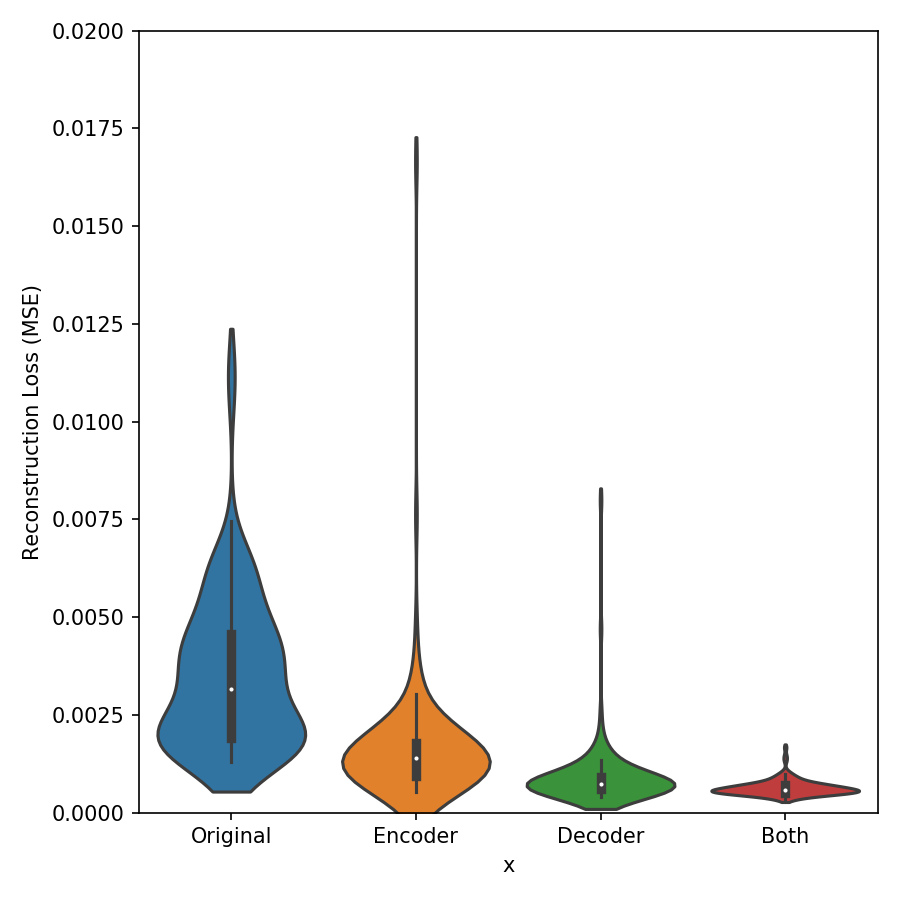

In [311]:
util.plot_distribs(samples, cut=True);
plt.ylim(0,0.02);
plt.xticks(range(len(mkeys)),mkeys)
plt.ylabel('Reconstruction Loss (MSE)')
plt.tight_layout();
# if figure_dir is not None:
#     util.save_figure(f'{setting}_{mcat}_losses',root=figure_dir)

In [312]:
model = runs['Original'].get_model()

In [313]:
fullQ = []
total = 10000
bs = 100
loader = dataset2.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [314]:
scales = fullQ.std(0)
# scales = None

In [315]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M = mats.min(1)[0].max(-1)[0]
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/20 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(torch.Size([6, 20, 12, 12]), 6, torch.Size([6, 12]))

<IPython.core.display.Javascript object>


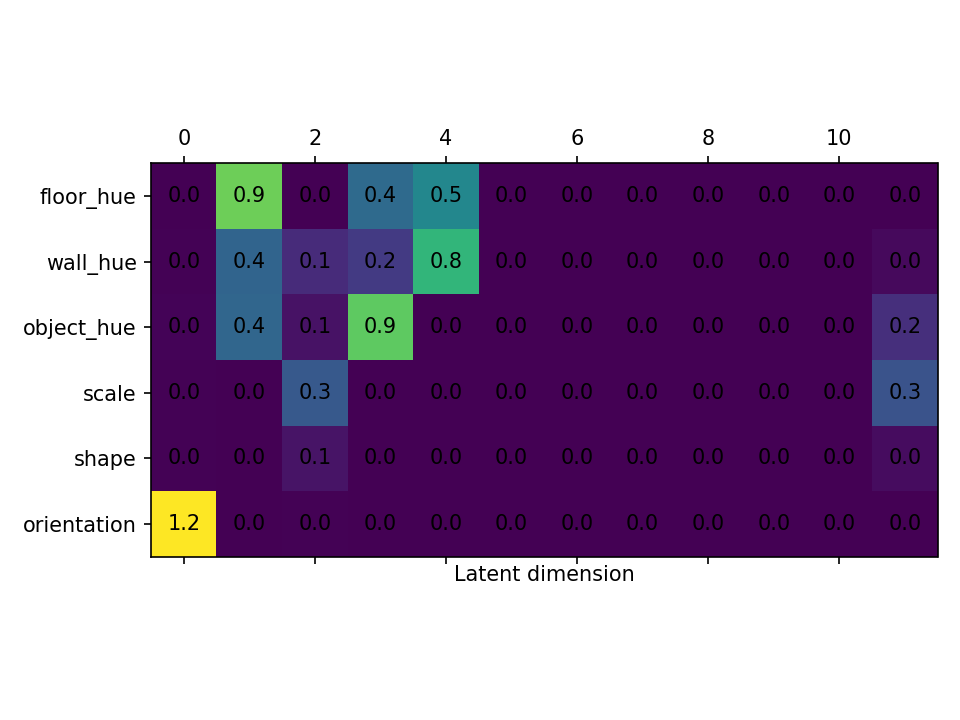

Figure xa_2VAE_factor-responses saved as {'png'}


In [316]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
util.save_figure(f'{setting}_{mname}_factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [322]:
# xas
dim = 1 # SAE
dim = 9 # 2VAE
# dim = 6

# xa
dim = 2 # sae
dim = 0 # 2vae

In [323]:
# vals = lats[...,dim]
# util.plot_hists(vals.cpu().detach());

<IPython.core.display.Javascript object>


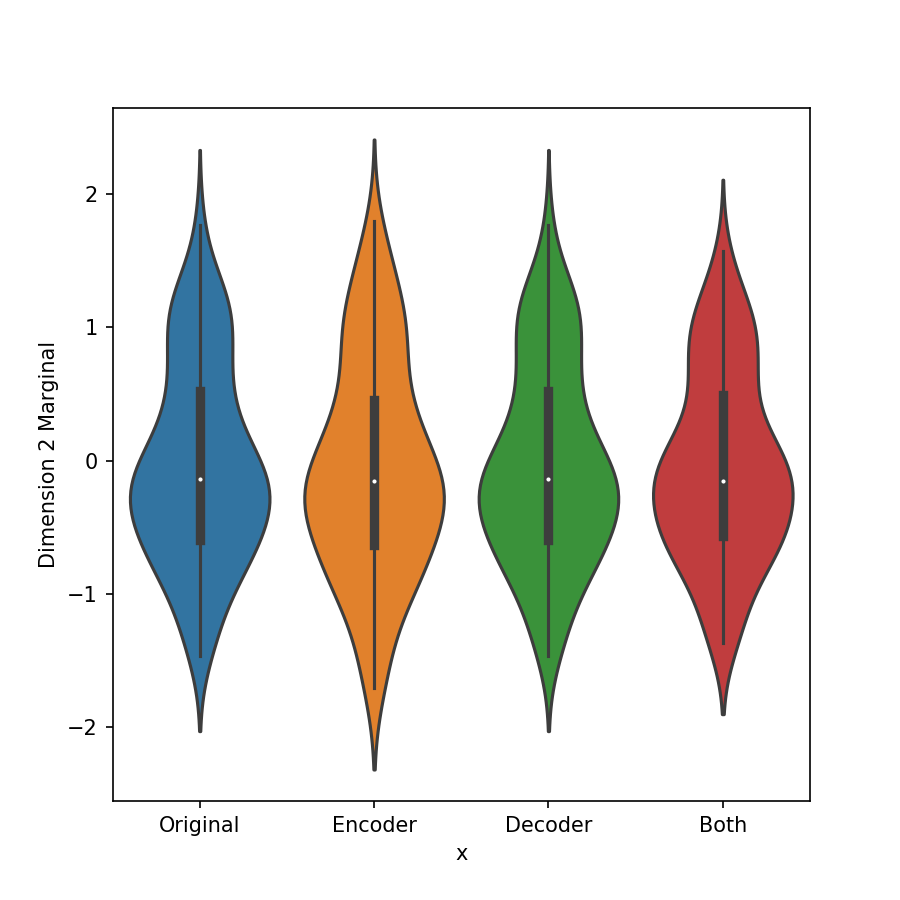

Text(0, 0.5, 'Dimension 2 Marginal')

In [324]:
vals = lats[...,dim]
util.plot_distribs(vals);
plt.xticks(range(len(mkeys)),mkeys)
plt.ylabel(f'Dimension {dim} Marginal')
util.save_figure(f'{setting}_{mname}_1d-latent-changes_dim{dim}', root=figure_dir)